In [261]:
# Enable autoreload for development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
# Setup
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [263]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [264]:
# Load and clean data
from src.load_data import load_data

In [265]:
df = load_data()
df

,No.,Diameter (mm),Speed (rpm),Feed (mm/rev),Thrust force (N),Torque (Nm),Flank wear (mm),Workpiece
0,1,9.0,500,0.13,1088.1,10.67,0.10,cast iron
1,2,9.0,500,0.18,1435.1,14.66,0.13,cast iron
2,3,9.0,500,0.25,1588.3,16.04,0.06,cast iron
3,4,9.0,500,0.36,1669.8,17.12,0.09,cast iron
4,5,9.0,400,0.13,1150.9,11.22,0.12,cast iron
...,...,...,...,...,...,...,...,...
160,161,10.0,1000,0.50,1960.0,18.13,0.13,copper
161,162,7.5,1000,0.50,784.0,7.35,0.10,copper
162,163,5.0,1000,0.50,651.0,6.17,0.07,copper
163,164,10.0,1000,0.71,2009.0,20.58,0.17,copper


In [266]:
from src.clean_data import clean_dataset, add_features
df_clean = clean_dataset(df)

In [267]:
df.shape

(165, 8)

In [268]:
df_clean = add_features(df_clean)  # ⬅️ Feature Engineering : this includes new features

In [269]:
# Identify one-hot workpiece columns (e.g., 'workpiece_b', 'workpiece_c', etc.)
workpiece_cols = [col for col in df_clean.columns if col.startswith('workpiece_')]

In [270]:
df_clean["thrust_force_(n)"] = df_clean["thrust_force_(n)"] / 1000

In [271]:
# Confirm all required columns exist
print("Cleaned Columns:", df_clean.columns.tolist())

Cleaned Columns: ['no.', 'diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)', 'thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)', 'workpiece_copper', 'workpiece_mild steel', 'speed_per_dia', 'log_feed', 'torque_feed_ratio', 'material_hardness', 'feed_squared', 'speed_squared']


In [272]:
df_clean.shape

(164, 15)

In [273]:
# Correlation of all features with Flank Wear
corr_matrix = df_clean.corr(numeric_only=True)
flank_corr = corr_matrix['flank_wear_(mm)'].sort_values(ascending=False)
print("Correlation with Flankwear")
display(flank_corr)


Correlation with Flankwear


flank_wear_(mm)         1.000000
diameter_(mm)           0.376967
thrust_force_(n)        0.366448
torque_feed_ratio       0.335095
torque_(nm)             0.214763
material_hardness       0.163496
workpiece_copper       -0.032785
no.                    -0.095608
feed_squared           -0.114098
workpiece_mild steel   -0.119936
feed_(mm/rev)          -0.129171
log_feed               -0.133833
speed_squared          -0.197722
speed_(rpm)            -0.204360
speed_per_dia          -0.334941
Name: flank_wear_(mm), dtype: float64

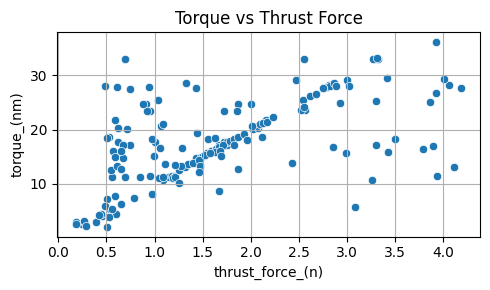

In [274]:
# for feature in ['diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)', 'workpiece_copper',
#                 #'thrust_force_(n)', 'flank_wear_(mm)', 'torque_(nm)' 
#                 'workpiece_mild steel', 'speed_per_dia', 'log_feed', 
#                 'torque_feed_ratio', 'material_hardness', 'torque_(nm)',
#                 'feed_squared', 'speed_squared']:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.scatterplot(data=df_clean, x='thrust_force_(n)', y='torque_(nm)')
plt.title("Torque vs Thrust Force")
plt.grid(True)
plt.tight_layout()
plt.show()


In [275]:
# Features and targets
X = df_clean[['diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)',
              'speed_per_dia', 'log_feed',
              'torque_feed_ratio', 'material_hardness',
              'feed_squared', 'speed_squared'] + workpiece_cols]
import numpy as np
# Target transformation: log-transform all 3 targets
y = df_clean[['thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)']].copy()

# Log-transform each to handle skewness and stabilize variance
for col in y.columns:
    y[col] = np.log1p(y[col])  # log1p avoids issues with zeros

Interpretation: (a)Torque values seem to follow a roughly normal distribution with no significant outliers.
(b)Flank wear had outliers or noise at the high end, which were removed during cleaning.

In [276]:
# Model tuning
from src.tune_models import tune_random_forest
best_rf, best_params, cv_results = tune_random_forest(X, y)
print("Best Params:", best_params)

import pandas as pd
cv_df = pd.DataFrame(cv_results)
cv_df = cv_df.sort_values(by='mean_test_score', ascending=False)
cv_df[['params', 'mean_test_score', 'rank_test_score']].head()

Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


,params,mean_test_score,rank_test_score
2,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.011457,1
56,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",0.011457,1
38,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.011457,1
65,"{'max_depth': 30, 'max_features': 'log2', 'min...",0.011457,1
47,"{'max_depth': 20, 'max_features': 'log2', 'min...",0.011457,1


In [277]:
# Model training and evaluation
from src.model_train import train_models

results = train_models(X, y)

# Extract test set and predictions (still log-scale here)
X_test = results['X_test']
y_test_log = results['y_test']      # ✅ rename for clarity
models = results['models']
metrics = results['metrics']

# ✅ Inverse transform log-scale targets for real-world evaluation
import numpy as np
y_test_orig = np.expm1(np.clip(y_test_log.values, 0, 20))

In [278]:
import pandas as pd

rows = []

for model_name, model_metrics in metrics.items():
    for i, target in enumerate(y.columns):
        if target == 'torque_(nm)':  # only process 'torque'
            row = {
                'Model': model_name,
                'Target': target,
                'R': model_metrics.get('R', [None]*len(y.columns))[i],
                'R2': model_metrics.get('R2', [None]*len(y.columns))[i],
                'MAE': model_metrics.get('MAE', [None]*len(y.columns))[i],
                'MSE': model_metrics.get('MSE', [None]*len(y.columns))[i],
                'RMSE': model_metrics.get('RMSE', [None]*len(y.columns))[i]
            }
            rows.append(row)

summary_df = pd.DataFrame(rows)
display(summary_df.sort_values(by='Model'))


,Model,Target,R,R2,MAE,MSE,RMSE
2,AdaBoost,torque_(nm),0.935694,0.816949,2.317338,12.839790,3.583265
0,RandomForest,torque_(nm),0.934361,0.845022,1.837797,10.870659,3.297068
1,XGBoost,torque_(nm),0.938658,0.857120,1.873045,10.022077,3.165766


In [279]:
from src.train_flankwear import train_flankwear_models
X = df_clean[['diameter_(mm)',
 'speed_(rpm)',
 'feed_(mm/rev)',
 'thrust_force_(n)',
 'torque_(nm)',
 #'flank_wear_(mm)',
 'workpiece_copper',
 'workpiece_mild steel',
 'speed_per_dia',
 'log_feed',
 'torque_feed_ratio',
 'material_hardness',
 'feed_squared',
 'speed_squared']]

y_flank = df_clean['flank_wear_(mm)']


In [280]:
results = train_flankwear_models(X, y_flank)

# Collect results into a list of dictionaries
table_data = []

for model_name, result in results.items():
    metrics = result['metrics']
    metrics['Model'] = model_name
    table_data.append(metrics)

# Convert to DataFrame
results_df = pd.DataFrame(table_data)

# Reorder columns (optional)
cols = ['Model', 'R', 'R2', 'MAE', 'MSE', 'RMSE', 'MAPE']
results_df = results_df[cols]

# Display the table
print("Results of Flankwear:")
print("----------------------")
print(results_df.to_string(index=False)) 


Results of Flankwear:
----------------------
       Model        R       R2      MAE      MSE     RMSE      MAPE
RandomForest 0.702490 0.401190 0.027771 0.001488 0.038570 33.523487
     XGBoost 0.871476 0.779162 0.023187 0.000876 0.029592 27.557532
    AdaBoost 0.570990 0.351403 0.030576 0.001568 0.039601 36.621997


In [ ]:
from src.train_thrustforce import train_thrustforce_models
X = df_clean[['diameter_(mm)',
 'speed_(rpm)',
 'feed_(mm/rev)',
 #'thrust_force_(n)',
 'torque_(nm)',
 'flank_wear_(mm)',
 'workpiece_copper',
 'workpiece_mild steel',
 'speed_per_dia',
 'log_feed',
 'torque_feed_ratio',
 'material_hardness',
 'feed_squared',
 'speed_squared']]

y_thrust = df_clean['thrust_force_(n)']


In [282]:
results = train_thrustforce_models(X, y_thrust)

# Collect results into a list of dictionaries
table_data = []

for model_name, result in results.items():
    metrics = result['metrics']
    metrics['Model'] = model_name
    table_data.append(metrics)

# Convert to DataFrame
results_df = pd.DataFrame(table_data)

# Reorder columns (optional)
cols = ['Model', 'R', 'R2', 'MAE', 'MSE', 'RMSE', 'MAPE']
results_df = results_df[cols]

# Display the table
print("Results of Thrustforce:")
print("----------------------")
print(results_df.to_string(index=False)) 


Results of Thrustforce:
----------------------
       Model        R       R2      MAE      MSE     RMSE      MAPE
RandomForest 0.980395 0.959887 0.138591 0.028976 0.170223 13.379178
     XGBoost 0.987809 0.975764 0.101853 0.017507 0.132314 10.995946
    AdaBoost 0.967916 0.935613 0.182768 0.046511 0.215663 17.880356
